# Accelerating Cleantech Advancements through NLP-Powered Text Mining and Knowledge Extraction

Group: Marusa Storman, Vignesh Govindaraj, Pradip Ravichandran

## Stage 2: Advanced Embedding Models Training and Analysis

### Load Data

In [1]:
import sys
import os

# Get the directory of the current notebook
notebook_dir = os.getcwd()

# Change current working directory to where the notebook resides
os.chdir(notebook_dir)

# List of required libraries
required_libraries = [
    'gensim',
    'scipy==1.12',
    'wordcloud'
]

# Check if each library is installed, if not, install it
for lib in required_libraries:
    try:
        __import__(lib)
    except ImportError:
        print(f"Installing {lib}...")
        !"{sys.executable}" -m pip install {lib}

Installing scipy==1.12...


In [2]:
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
import seaborn as sns

from gensim.models import Word2Vec
from wordcloud import WordCloud

# Jupyter config
%config InteractiveShell.ast_node_interactivity = 'all'

# Additional setup for seaborn
sns.set(color_codes=True)
sns.set_style("whitegrid")

In [3]:
patent_train = pd.DataFrame()
patent_val = pd.DataFrame()
media_train = pd.DataFrame()
media_val = pd.DataFrame()

#### Load Word Training

In [4]:
def load_all_models(load_dir: str) -> dict[str, Word2Vec]:
    models: dict[str, Word2Vec] = {}
    for filename in os.listdir(load_dir):
        if filename.endswith('.model'):
            model_name = filename.split('.model')[0]
            model_path = os.path.join(load_dir, filename)
            model = Word2Vec.load(model_path)
            models[model_name] = model
            print(f'Model {model_name} loaded from {model_path}')
    return models

In [5]:
patent_word_title_models = load_all_models("Data/Word/Patent/Title")
patent_word_text_models = load_all_models("Data/Word/Patent/Text")

media_word_title_models = load_all_models("Data/Word/Media/Title")
media_word_text_models = load_all_models("Data/Word/Media/Text")

Model patent_title_100_10_10 loaded from Data/Word/Patent/Title\patent_title_100_10_10.model
Model patent_title_100_10_20 loaded from Data/Word/Patent/Title\patent_title_100_10_20.model
Model patent_title_100_5_10 loaded from Data/Word/Patent/Title\patent_title_100_5_10.model
Model patent_title_100_5_20 loaded from Data/Word/Patent/Title\patent_title_100_5_20.model
Model patent_title_200_10_10 loaded from Data/Word/Patent/Title\patent_title_200_10_10.model
Model patent_title_200_10_20 loaded from Data/Word/Patent/Title\patent_title_200_10_20.model
Model patent_title_200_5_10 loaded from Data/Word/Patent/Title\patent_title_200_5_10.model
Model patent_title_200_5_20 loaded from Data/Word/Patent/Title\patent_title_200_5_20.model
Model patent_abstract_100_10_10 loaded from Data/Word/Patent/Text\patent_abstract_100_10_10.model
Model patent_abstract_100_10_20 loaded from Data/Word/Patent/Text\patent_abstract_100_10_20.model
Model patent_abstract_100_5_10 loaded from Data/Word/Patent/Text\pat

#### Load Sentence Training

In [6]:
# Load the embeddings from CSV files into DataFrames
patent_train_titles_df = pd.read_csv('Data/Sentence/google_patent_en_train_titles_embeddings.csv')
patent_val_titles_df = pd.read_csv('Data/Sentence/google_patent_en_val_titles_embeddings.csv')
patent_train_abstracts_df = pd.read_csv('Data/Sentence/google_patent_en_train_abstracts_embeddings.csv')
patent_val_abstracts_df = pd.read_csv('Data/Sentence/google_patent_en_val_abstracts_embeddings.csv')

# Merge the embeddings DataFrame with the original patent_train DataFrame
patent_train_titles = pd.concat([patent_train, patent_train_titles_df], axis=1)
patent_train.rename(columns=lambda x: 'title_embedding' if 'Unnamed' in x else x, inplace=True)
patent_train = pd.concat([patent_train, patent_train_abstracts_df], axis=1)
patent_train.rename(columns=lambda x: 'abstract_embedding' if 'Unnamed' in x else x, inplace=True)

patent_val = pd.concat([patent_val, patent_val_titles_df], axis=1)
patent_val.rename(columns=lambda x: 'title_embedding' if 'Unnamed' in x else x, inplace=True)
patent_val = pd.concat([patent_val, patent_val_abstracts_df], axis=1)
patent_val.rename(columns=lambda x: 'abstract_embedding' if 'Unnamed' in x else x, inplace=True)

In [7]:
# Load the embeddings from CSV files into DataFrames
media_train_titles_df = pd.read_csv('Data/Sentence/media_train_titles_embeddings.csv')
media_val_titles_df = pd.read_csv('Data/Sentence/media_val_titles_embeddings.csv')
# media_train_abstracts_df = pd.read_csv('Data/Sentence/media_train_content_embeddings.csv')
# media_val_abstracts_df = pd.read_csv('Data/Sentence/media_val_content_embeddings.csv')

# Merge the embeddings DataFrame with the original patent_train DataFrame
media_train_titles = pd.concat([media_train, media_train_titles_df], axis=1)
media_train.rename(columns=lambda x: 'title_embedding' if 'Unnamed' in x else x, inplace=True)
# media_train = pd.concat([media_train, media_train_abstracts_df], axis=1)
# media_train.rename(columns=lambda x: 'content_embedding' if 'Unnamed' in x else x, inplace=True)

media_val = pd.concat([media_val, media_val_titles_df], axis=1)
media_val.rename(columns=lambda x: 'title_embedding' if 'Unnamed' in x else x, inplace=True)
# media_val = pd.concat([media_val, media_val_abstracts_df], axis=1)
# media_val.rename(columns=lambda x: 'content_embedding' if 'Unnamed' in x else x, inplace=True)

### Exploratory Data Analysis

#### Word similarity

In [8]:
# Function to create and display a word cloud
def create_word_cloud(model, title):
    word_freq = {word: model.wv.get_vecattr(word, 'count') for word in model.wv.index_to_key}
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(title)
    plt.axis('off')
    plt.show()


# Function to create and display similar words using Seaborn
def create_seaborn_barplot(df, word):
    plt.figure(figsize=(14, 8))
    sns.barplot(x='Similarity', y='SimilarWord', hue='Model', data=df, dodge=True)
    plt.title(f'Top 5 Most Similar Words to "{word}" Across Different Word2Vec Models')
    plt.xlabel('Similarity')
    plt.ylabel('Similar Word')
    plt.legend(title='Model', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.show()

def create_heatmap(df, word):
    plt.figure(figsize=(12, 8))
    sns.heatmap(heatmap_data, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title(f'Heatmap of Top 5 Most Similar Words to "{word}" in Patent Abstracts')
    plt.xlabel('Model')
    plt.ylabel('Similar Word')
    plt.show()

# Function to visualize word similarities using a network graph
def visualize_similar_words_network(similarities, title):
    G = nx.Graph()
    for model_name, group_data in similarities.groupby('Model'):
        for _, row in group_data.iterrows():
            G.add_edge(row['Word'], row['SimilarWord'], weight=row['Similarity'])

    pos = nx.spring_layout(G, k=1.5)
    plt.figure(figsize=(12, 8))
    edges, weights = zip(*nx.get_edge_attributes(G, 'weight').items())
    nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=5000, font_size=10, edge_color=weights, edge_cmap=plt.cm.Blues, width=2)
    plt.title(title)
    plt.show()


# Function to evaluate word similarity, TODO: if not used, remove
def evaluate_word_similarity(word2vec_model, word_pairs):
    similarities = []
    for pair in word_pairs:
        word1, word2 = pair
        if word1 in word2vec_model.wv and word2 in word2vec_model.wv:
            similarity = cosine_similarity([word2vec_model.wv[word1]], [word2vec_model.wv[word2]])[0][0]
            similarities.append(similarity)
    return similarities

# Function to get top n similar words for a given word from all models
def get_top_similar_words(models, word, topn=5):
    similar_words = []
    for model_name, model in models.items():
        similar_words.extend([(model_name, word, *sim) for sim in model.wv.most_similar(word, topn=topn)])
    return similar_words

In [9]:
# Function to evaluate word similarity, TODO: if not used, remove
def evaluate_word_similarity(word2vec_model, word_pairs):
    similarities = []
    for pair in word_pairs:
        word1, word2 = pair
        if word1 in word2vec_model.wv and word2 in word2vec_model.wv:
            similarity = cosine_similarity([word2vec_model.wv[word1]], [word2vec_model.wv[word2]])[0][0]
            similarities.append(similarity)
    return similarities

# Function to get top n similar words for a given word from all models
def get_top_similar_words(models, word, topn=5):
    similar_words = []
    for model_name, model in models.items():
        similar_words.extend([(model_name, word, *sim) for sim in model.wv.most_similar(word, topn=topn)])
    return similar_words

##### Google patent

###### Title

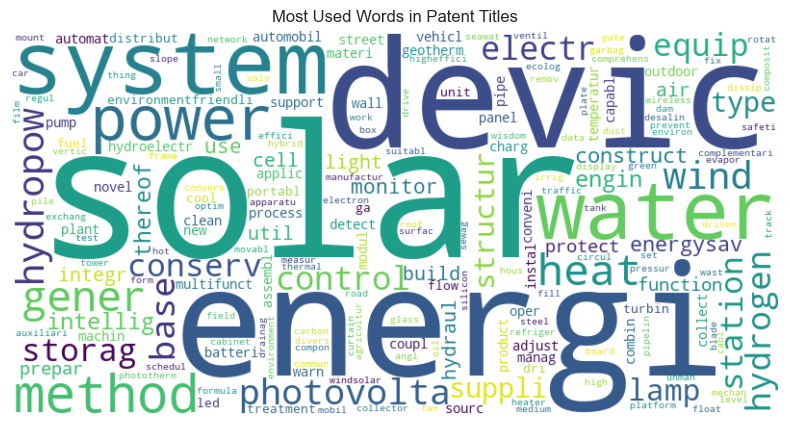

In [10]:
# Create word clouds for the most used words
first_model_name, first_model = next(iter(patent_word_title_models.items()))
create_word_cloud(first_model, "Most Used Words in Patent Titles")

In [11]:
check_similar = input("Enter a similar word:")

Enter a similar word: solar


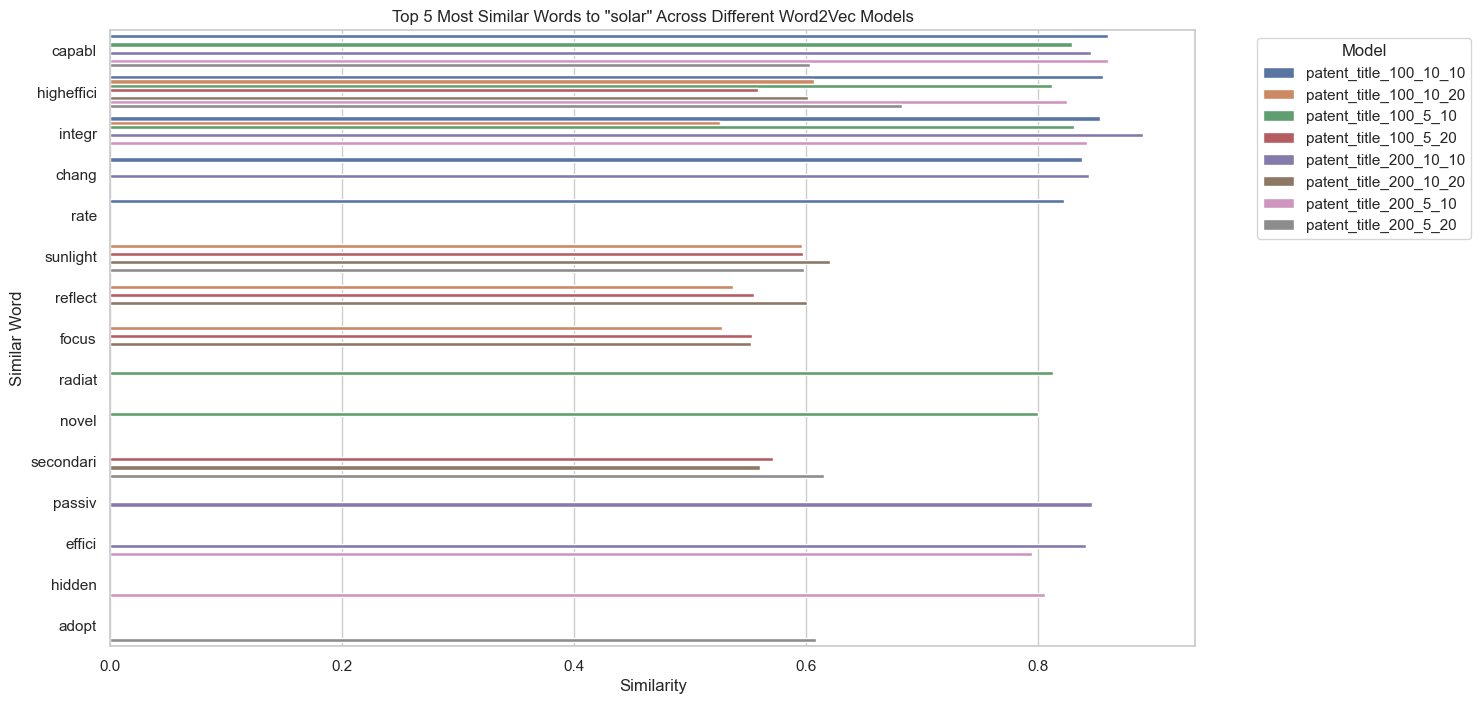

In [12]:
# Get top 5 similar words to 'solar' from all models
top_similar_words = get_top_similar_words(patent_word_title_models, check_similar, topn=5)

# Create a DataFrame for visualization
df_similar_words = pd.DataFrame(top_similar_words, columns=['Model', 'Word', 'SimilarWord', 'Similarity'])

# Plot the similar words using Seaborn
create_seaborn_barplot(df_similar_words, check_similar)

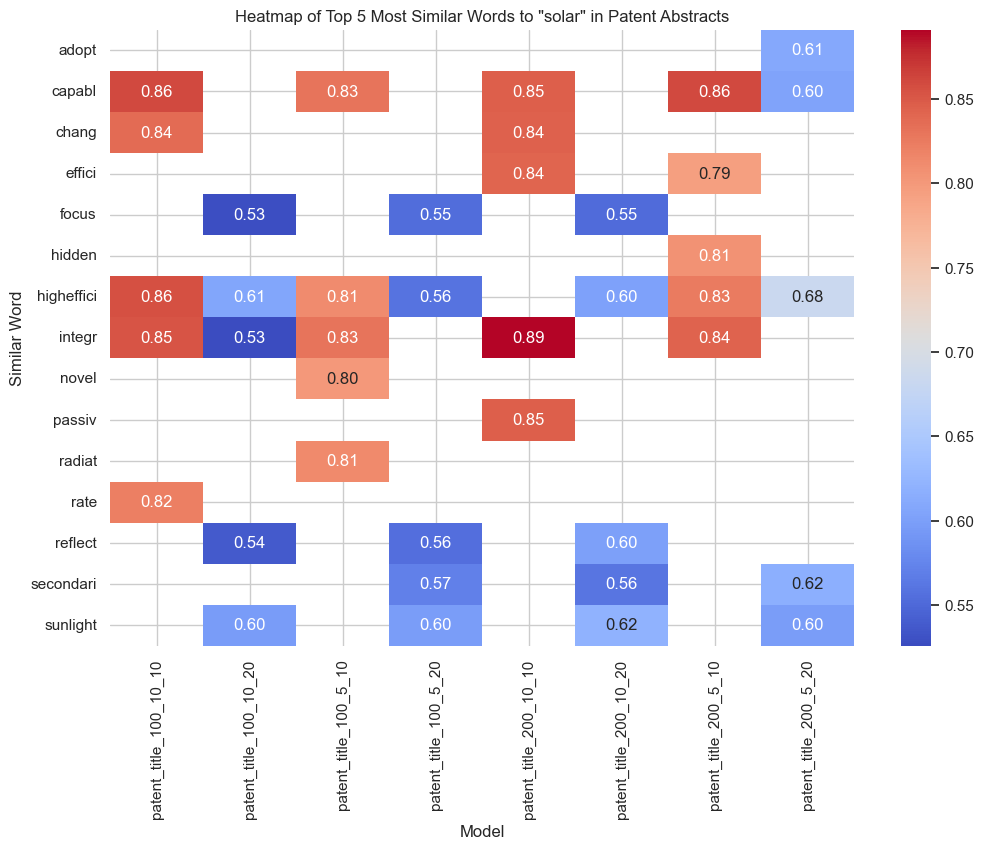

In [13]:
heatmap_data = df_similar_words.pivot_table(index='SimilarWord', columns='Model', values='Similarity', aggfunc='first')
create_heatmap(heatmap_data, check_similar)

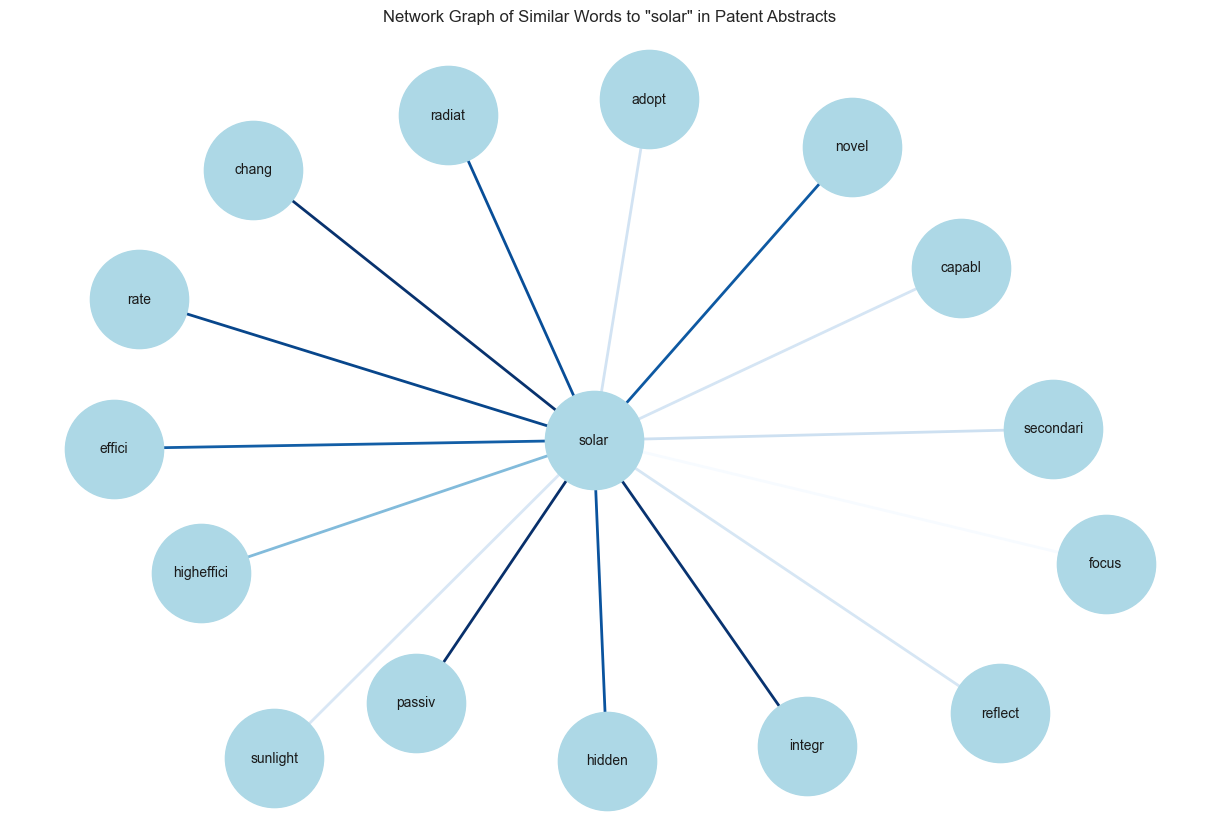

In [14]:
# Visualize using network graph
visualize_similar_words_network(df_similar_words, f'Network Graph of Similar Words to "{check_similar}" in Patent Abstracts')

###### Text

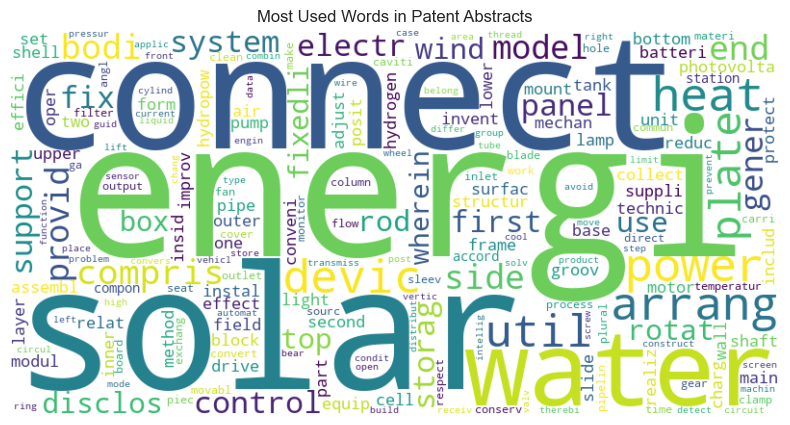

In [15]:
# Create word clouds for the most used words
first_model_name, first_model = next(iter(patent_word_text_models.items()))
create_word_cloud(first_model, "Most Used Words in Patent Abstracts")

In [16]:
check_similar = input("Enter a similar word: ") 

Enter a similar word:  solar


In [17]:
# Get top 5 similar words to the check_similar word from all abstract models
top_similar_text_words = get_top_similar_words(patent_word_text_models, check_similar, topn=5)

# Create a DataFrame for visualization
df_similar_text_words = pd.DataFrame(top_similar_text_words, columns=['Model', 'Word', 'SimilarWord', 'Similarity'])

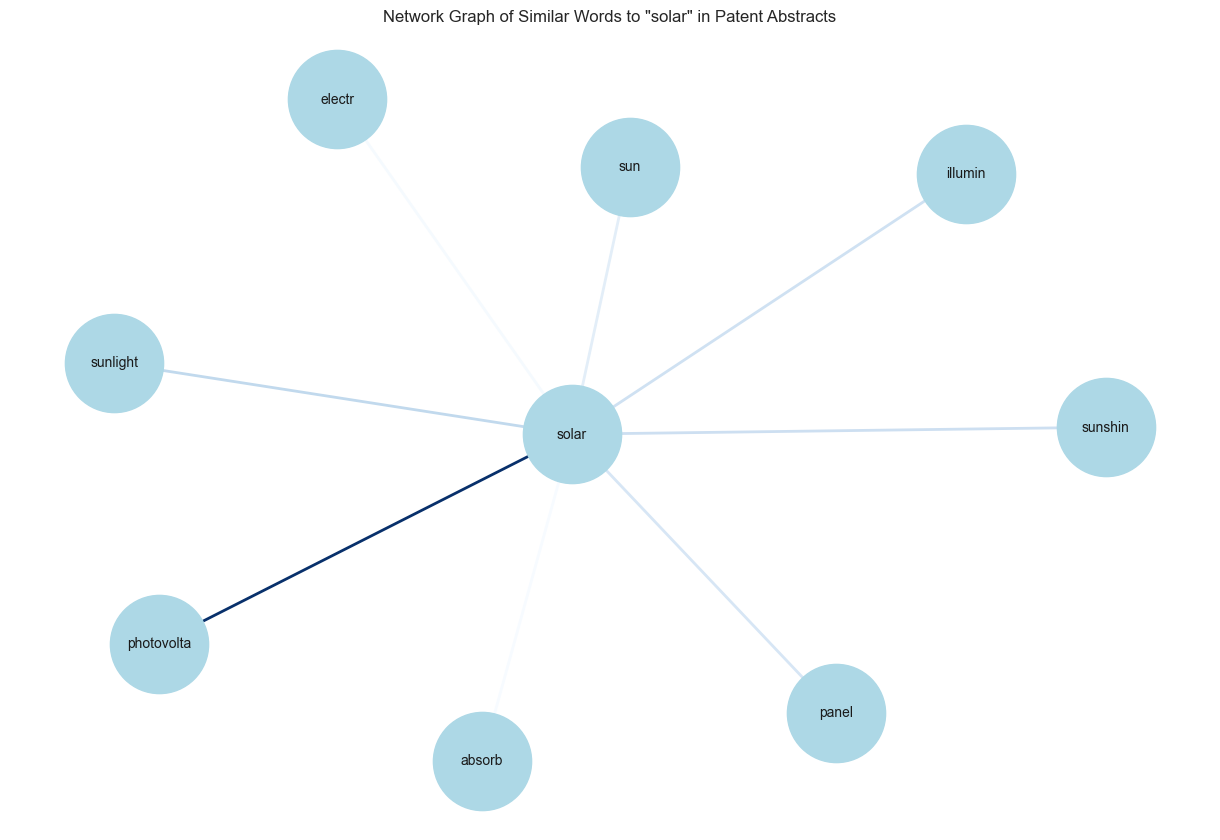

In [18]:
# Visualize using network graph
visualize_similar_words_network(df_similar_text_words, f'Network Graph of Similar Words to "{check_similar}" in Patent Abstracts')

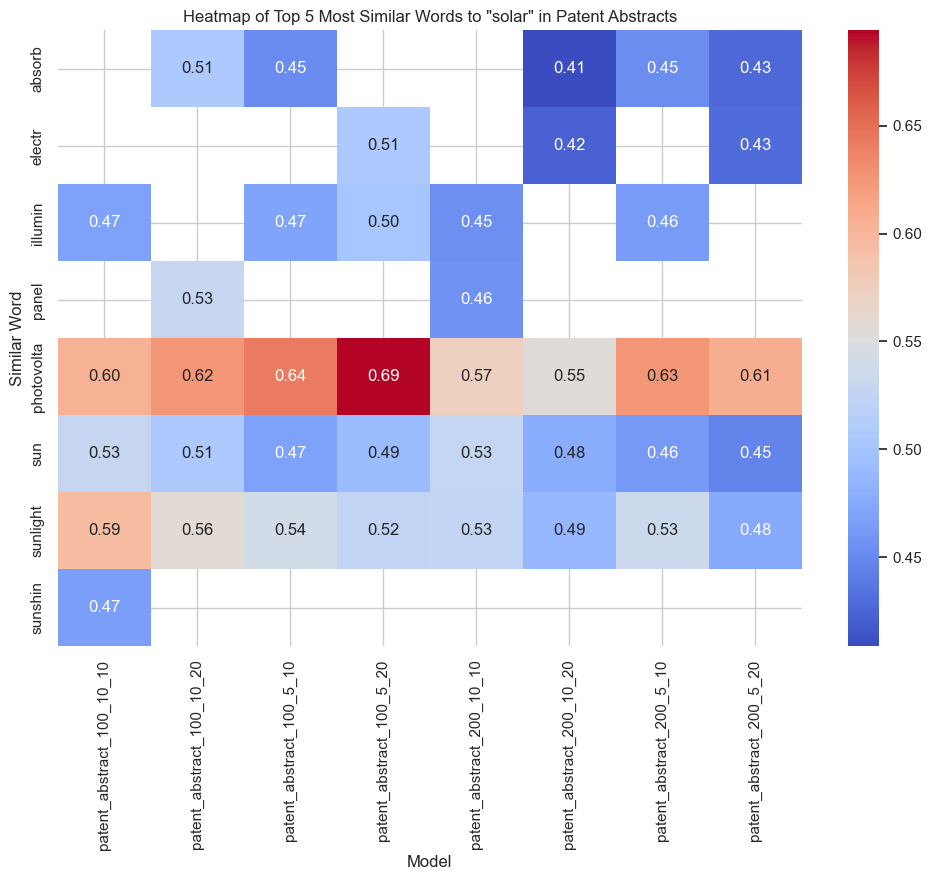

In [19]:
# Create a heatmap for the similar words
heatmap_data = df_similar_text_words.pivot_table(index='SimilarWord', columns='Model', values='Similarity', aggfunc='first')
create_heatmap(heatmap_data, check_similar)

In [20]:
abstract_lang_distribution = google_patent['abstract_localized_language'].value_counts().reset_index()
title_lang_distribution = google_patent['title_localized_language'].value_counts().reset_index()

NameError: name 'google_patent' is not defined

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(20, 10))

# Plot for language distribution in abstracts
sns.barplot(ax=axes[0], x=[item[0] for item in abstract_lang_distribution.values], 
            y=[item[1] for item in abstract_lang_distribution.values], color='skyblue')
axes[0].set_title('Language Distribution in Abstracts')
axes[0].set_xlabel('Number of Abstracts')
axes[0].set_ylabel('Language')

# Plot for language distribution in titles
sns.barplot(ax=axes[1], x=[item[0] for item in title_lang_distribution.values], 
            y=[item[1] for item in title_lang_distribution.values], color='lightgreen')
axes[1].set_title('Language Distribution in Titles')
axes[1].set_xlabel('Number of Titles')
axes[1].set_ylabel('Language')

plt.tight_layout()
plt.show();

##### Cleantech Media

##### Common

#### Word analogy

In [21]:
# Function to get analogies for all models
def get_analogies(models, word1, word2, word3, topn=5):
    try:
        analogies = []
        for model_name, model in models.items():
            result = model.wv.most_similar(positive=[word3, word2], negative=[word1], topn=topn)
            analogies.extend([(model_name, word1, word2, word3, *analogy) for analogy in result])
        return analogies
    except KeyError:
        return []
	
	
# Function to visualize word analogies using a network graph
def visualize_analogies_network(analogies, title):
    G = nx.Graph()
    for model_name, group_data in analogies.groupby('Model'):
        for _, row in group_data.iterrows():
            G.add_edge(f"{row['Word1']}:{row['Word2']}", f"{row['Word3']}:{row['SimilarWord']}", weight=row['Similarity'])
    pos = nx.spring_layout(G, k=1.5)
    plt.figure(figsize=(12, 8))
    edges, weights = zip(*nx.get_edge_attributes(G, 'weight').items())
    nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=5000, font_size=10, edge_color=weights, edge_cmap=plt.cm.Blues, width=2)
    plt.title(title)
    plt.show()
	
	
# Example function to handle user input and visualize analogies
def analyze_word_analogies(models):
    word1 = input("Enter the first word (word1): ")
    word2 = input("Enter the second word (word2): ")
    word3 = input("Enter the third word (word3): ")
    # Get analogies from models
    analogies = get_analogies(models, word1, word2, word3, topn=5)
    # Create a DataFrame for visualization
    df_analogies = pd.DataFrame(analogies, columns=['Model', 'Word1', 'Word2', 'Word3', 'SimilarWord', 'Similarity'])
    # Visualize using network graph
    visualize_analogies_network(df_analogies, f'Network Graph of Analogies for "{word1}:{word2} as {word3}:?"')

In [22]:
# Function to evaluate word analogy
def evaluate_word_analogy(model, analogy_pairs):
    correct_count = 0
    total_count = 0
    for analogy in analogy_pairs:
        if all(word in word2vec_model.wv for word in analogy):
            word1, word2, word3, word4 = analogy
            predicted_word = word2vec_model.wv.most_similar(positive=[word2, word3], negative=[word1])[0][0]
            if predicted_word == word4:
                correct_count += 1
            total_count += 1
    accuracy = correct_count / total_count if total_count > 0 else 0
    return accuracy

##### Google patent

###### Google patent title

Enter the first word (word1):  solar
Enter the second word (word2):  power
Enter the third word (word3):  water


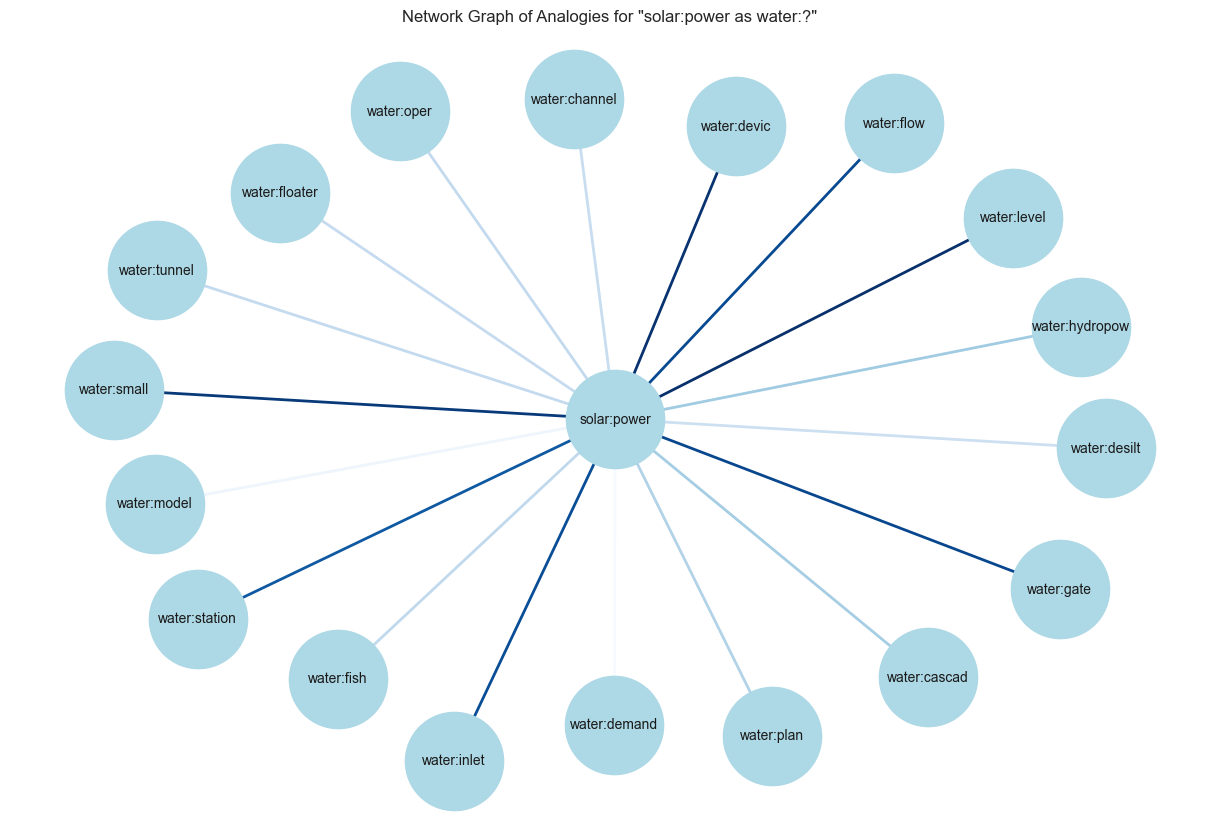

In [23]:
analyze_word_analogies(patent_word_title_models)

###### Google patent text

##### Cleantech Media

###### Title

###### Text

##### Common

#### Sentence similarity